#### Limitations
So far, all solvers use uniform cell sizes and work only in 1D (however, `LinearSolver` seems to be almost ready for 2D simulations). Material properties are also assumed constant in the domain.

In [1]:
using PyPlot
using LinearAlgebra
using Statistics
include("boundary_conditions.jl");

#### Define a gradient operator
That can differentiate an electric potential field to obtain an electric field.
In order to improve performance, ∇ can be called with a preallocated result and
can flip sign in the result.

In [2]:
using StaticArrays
include("gradient.jl")

#### In-place Periodic Solver
Is aimed at solving a periodic Poisson equation without explicitely assembling the
system of linear equations. As it is a singular problem, which is non-determined
up to a constant value, the result has to be solved iteratively and some additional
constraints have to be imposed. In this case we assume that the mean value of the
solution is 0. We achieve this by substracting the original solution's mean value.

In [3]:
include("iterative_methods.jl")
include("inplace_periodic_solver.jl")

apply!(::InPlacePeriodicSolver, ::PeriodicBC, ::Symbol) = nothing
solution(ps::InPlacePeriodicSolver) = ps.u
gradient(ps::InPlacePeriodicSolver) = let periodic = PeriodicBC()
    GradientOperator(ps.nx, ps.δx, (periodic, periodic), (:left, :right))
end

gradient (generic function with 1 method)

#### Linear Solver
The former solver was limited by the fact that it worked only for periodic boundary conditions. The linear solver is aimed at solving a general Poisson equations with both periodic and Dirichlet boundary conditions. It forms a system of linear equations.

In [4]:
using SparseArrays
include("linear_solver.jl")

solution(ps::LinearSolver) = reshape(ps.u, ps.n...)
gradient(ps::LinearSolver) = GradientOperator(ps.n[1], ps.δ[:], ps.bcs, ps.bnds)

gradient (generic function with 2 methods)

#### Some additional solvers
(work-in-progress)

In [5]:
struct MutligridSolver end
struct FastFourierTransformSolver end

#### General problem parameters
The Poisson equation is solved on a domain with $x \in <0, 1>$ using a Finite Volume Method approach.
The source term is defined as $f(x) = (72\pi)^2 \sin(4\pi x) \sin(2\pi x)$.

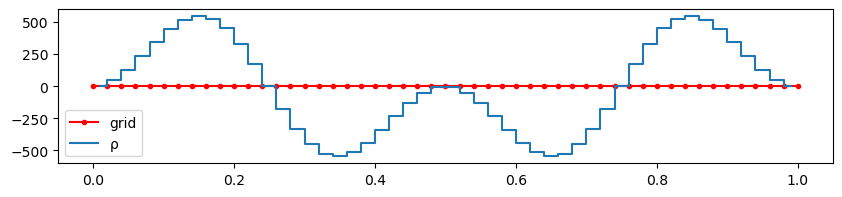

In [6]:
h  = 0.02
xf = 0.0:h:1.0
xc = 0.5 .* xf[1:end-1] .+
     0.5 .* xf[2:end]
φref = @.        cos(2π * 3xc)-9cos(2π * xc)
f(x) = 72.0π^2 * sin(2π * 2x) * sin(2π * x)
ρ = f.(xc)
ρ.-= mean(ρ) # substract mean value as it is a crucial condition

bc = PeriodicBC()
figure(figsize=(10, 2))
plot(xf, zero(xf), "r.-")
step(xc, ρ, where="mid")
legend(["grid", "ρ"]);

The above problem is solved using a Linear Solver. We can apply both periodic and Dirichlet boundary conditions.
In the case of boundary conditions on both boundaries we can impose additional constraint on a mean solution value. This is the reason why we substract the mean solution value after calculating the electric potential.

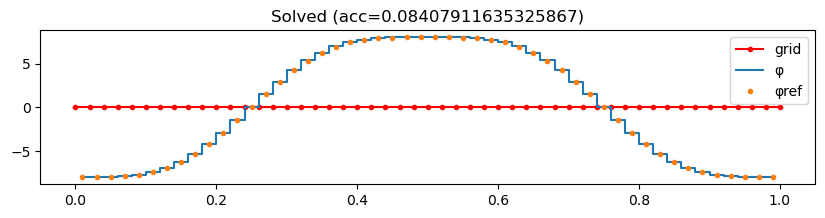

  0.470847 seconds (2.68 M allocations: 149.598 MiB, 7.92% gc time, 99.77% compilation time)


In [7]:
ps = LinearSolver(xf, left=bc, right=bc)
apply!(ps, bc,  :left)
apply!(ps, bc, :right)
@time it = solve!(ps, ρ)
φ  = solution(ps)
φ.-= mean(φ) # substract mean value when both boundary conditions are periodic

figure(figsize=(10, 2))
title("Solved (acc=$(norm(φ - φref)))")
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
plot(xc, φref, ".")
legend(["grid", "φ", "φref"]);

Once again the same Poisson equation is being solved with periodic boundary conditions on both boundaries. In this case the `solve!` procedure substract the mean value in the end.

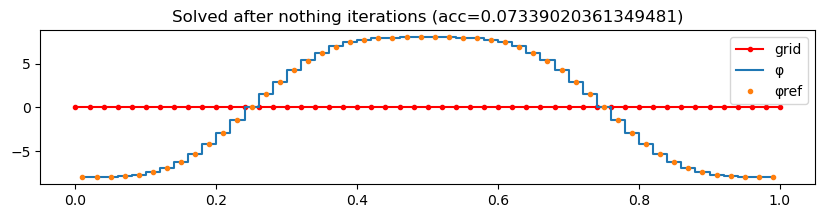

  0.132695 seconds (768.73 k allocations: 43.865 MiB, 7.16% gc time, 99.71% compilation time)


In [8]:
ps = InPlacePeriodicSolver(xf; maxiter=1000)
apply!(ps, bc,  :left)
apply!(ps, bc, :right)
@time it = solve!(ps, ρ)
φ  = solution(ps)
φ.-= mean(φ) # substract mean value when both boundary conditions are periodic

figure(figsize=(10, 2))
title("Solved after $it iterations (acc=$(norm(φ - φref)))")
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
plot(xc, φref, ".")
legend(["grid", "φ", "φref"]);

Now we can also differentiate the electric potential and obtain the electric field which uses the information about boundaries.

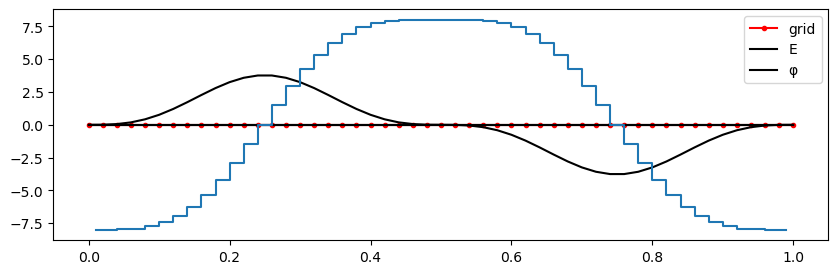

  106.312 ns (1 allocation: 16 bytes)


In [9]:
using BenchmarkTools
E = zeros(SVector{3, Float64}, length(xf));
∇ = gradient(ps)
@btime ∇($φ; result=$E)

figure(figsize=(10, 3))
plot(xf, zero(xf), "r.-")
plot(xf, 0.05E, "k-")
step(xc, φ, where="mid")
legend(["grid", "E", "φ"]);

#### Compare convergence of different methods
Comparison between iterative solvers both from Julia's IterativeSolvers.jl and our own.

In [10]:
import IterativeSolvers

ps = LinearSolver(xf, left=bc, right=bc)
apply!(ps, bc,  :left)
apply!(ps, bc, :right)
nothing

It seems that GMRES has a good convergence on the given problem

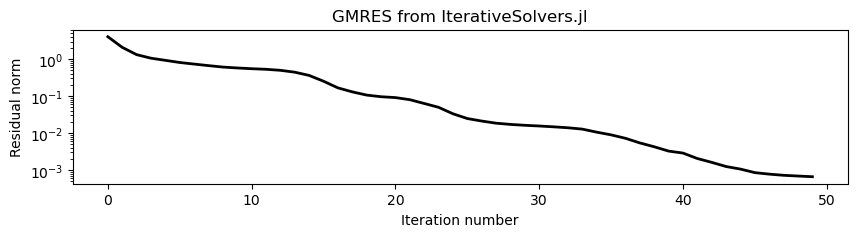

  0.005219 seconds (9.02 k allocations: 577.203 KiB, 90.99% compilation time)


In [11]:
x = randn(length(ps.u))
rhs = ps.b .- ρ .* h .^ 2
x, ch = IterativeSolvers.gmres!(x, ps.A, rhs, log=true)
resnorm = ch.data[:resnorm]

x = randn(length(ps.u))
@time IterativeSolvers.gmres!(x, ps.A, rhs)

figure(figsize=(10, 2))
title("GMRES from IterativeSolvers.jl")
xlabel("Iteration number")
ylabel("Residual norm")
semilogy(resnorm, linewidth=2, linestyle="-", color="k");

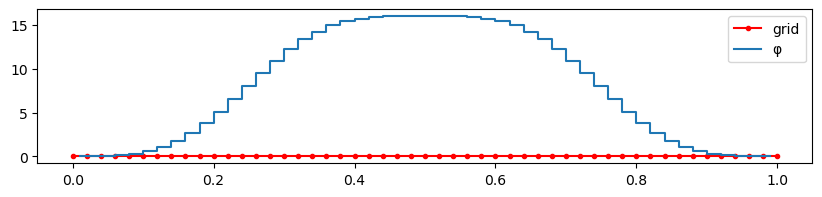

  0.060527 seconds (64.32 k allocations: 3.298 MiB, 99.01% compilation time)


In [12]:
ps = LinearSolver(xf, left=DirichletBC(), right=DirichletBC())
@time it = solve!(ps, ρ)
φ  = solution(ps)

figure(figsize=(10, 2))
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
legend(["grid", "φ", "φref"]);

In [13]:
function solve!(ps::LinearSolver, ρ)
    rhs = ps.b .- ρ .* h .^ 2 # extra allocation
    ps.u .= ps. A \ rhs
    return nothing
end

solve! (generic function with 2 methods)

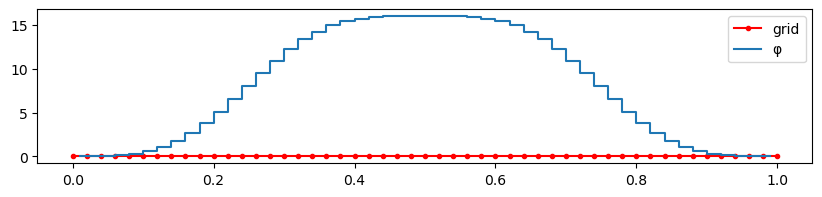

  1.557695 seconds (6.91 M allocations: 402.959 MiB, 5.51% gc time)


In [14]:
ps = LinearSolver(xf, left=DirichletBC(), right=DirichletBC())
@time it = solve!(ps, ρ)
φ  = solution(ps)

figure(figsize=(10, 2))
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
legend(["grid", "φ", "φref"]);